In [1]:
from surprise.model_selection.validation import cross_validate
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import KFold
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import  roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
file_name = 'ratings.csv'#Please change this path into absolute path to "ratings.csv"
data_raw = pd.read_csv(file_name)
data_table = data_raw.pivot_table(values = 'rating', index = ['userId'], columns = ['movieId'], fill_value=0)
data_mat = pd.DataFrame.as_matrix(data_table)
movieId = list(data_table.columns)
userId = list(data_table.index)

D:\Softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [3]:
def get_roc(model, data, thres):
    x_train, x_test = train_test_split(data, test_size = 0.1)
    model.fit(x_train)
    predictions = model.test(x_test)
    y_test = []
    y_label = []
    for i in range(len(predictions)):
        y_test.append(predictions[i].est)
    for i in range(len(x_test)):
        if x_test[i][2] >= thres:
            y_label.append(1.0)
        else:
            y_label.append(0.0)
            
    fpr, tpr, _ = roc_curve(y_label, y_test)
    AUC = roc_auc_score(y_label, y_test)
    return fpr, tpr, AUC

In [4]:
reader = Reader(line_format='user item rating', sep=',', skip_lines=1, rating_scale=(0.5, 5))
data = Dataset.load_from_file(file_name, reader=reader)
threshold = 3

In [5]:
sim_options = {'name': 'pearson'}
knn = KNNWithMeans(k=40, sim_options=sim_options, verbose = False)
knn_fpr, knn_tpr, knn_auc = get_roc(knn, data, threshold)

nnmf = NMF(n_factors=18, biased = False)
nnmf_fpr, nnmf_tpr, nnmf_auc = get_roc(nnmf, data, threshold)

nmf_biased = SVD(n_factors=18)
mf_bias_fpr, mf_bias_tpr, mf_bias_auc = get_roc(nmf_biased, data, threshold)

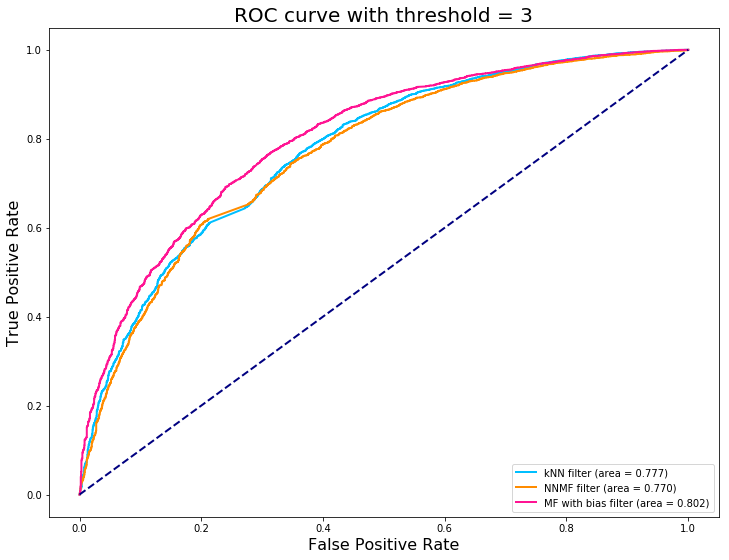

In [8]:
plt.figure(figsize=(12,9))
plt.plot(knn_fpr, knn_tpr, color='deepskyblue', lw=2, label='kNN filter (area = %0.3f)' % knn_auc)
plt.plot(nnmf_fpr, nnmf_tpr, color='darkorange', lw=2, label='NNMF filter (area = %0.3f)' % nnmf_auc)
plt.plot(mf_bias_fpr, mf_bias_tpr, color='deeppink', lw=2, label='MF with bias filter (area = %0.3f)' % mf_bias_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve with threshold = 3', fontsize=20)
plt.legend(loc="lower right")
fig = plt.gcf()
plt.show()
fig.savefig('ROC curve with threshold = 3.png', dpi=300, bbox_inches = 'tight')